+ Write anything you need to test

In [1]:
import pandas as pd
import numpy as np
import pickle

from tqdm import tqdm

from tools import Train, validation, GridSearch

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import r2_score, mean_absolute_error

In [3]:
with open('data/train_dataset.pickle', 'rb') as f:
    train_dataset = pickle.load(f)

with open('data/val_dataset.pickle', 'rb') as f:
    val_dataset = pickle.load(f)

with open('data/test_dataset.pickle', 'rb') as f:
    test_dataset = pickle.load(f)

In [4]:
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 64, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [5]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=0)

In [6]:
criterion = nn.MSELoss()
eval_metrics = [
    r2_score,
    mean_absolute_error
]

In [7]:
class SimpleLSTM(nn.Module):
    def __init__(self, n, m, num_layers):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=n, hidden_size=m, num_layers=num_layers, batch_first=False)
        self.linear_output = nn.Sequential(
            nn.Linear(m, 2*m),
            nn.ReLU(),
            nn.Linear(2*m, 1)
        )
    

    def forward(self, X): # (-1 x T x n)
        X = X.permute(1, 0, 2) # (T x -1 x n)
        output, _ = self.lstm(X) # (T x -1 x m), ((`num_layers` x -1 x m), (`num_layers` x -1 x m))
        output = output[-1] # (-1 x m)
        output = self.linear_output(output).squeeze(dim=1) # (-1 x 1) -> (-1)

        return output

In [8]:
basic_params = {
    'n': 40
}

param_grid = {
    'm': [128, 32, 40],
    'num_layers': [1, 2, 3]
}

model_name = 'Simple_LSTM_unmasked'
grid_model = GridSearch(criterion, eval_metrics, device, temp_save_path=f'checkpoints/model_by_param/temp_{model_name}.pt', masked=False)
best_model = grid_model.train_by_grid(
        SimpleLSTM, basic_params, param_grid,
        torch.optim.Adam, train_loader, val_loader,
        patience=3, epochs=20,
        save_filename=f'checkpoints/{model_name}_best.pt'
    )

Total   9 cases are going to be searched.
Setting   0 of Parameters Grid is now on progres.


Epoch  7: 100%|██████████| 1304/1304 [00:03<00:00, 422.73it/s, Train Loss=0.4463, Valid Loss=0.4829, Valid R2=-0.0896, Valid MAE=0.4910]


Early Stopped
Setting   1 of Parameters Grid is now on progres.


Epoch  4: 100%|██████████| 1304/1304 [00:03<00:00, 353.33it/s, Train Loss=0.2311, Valid Loss=0.3439, Valid R2=0.2241, Valid MAE=0.4393]


Early Stopped
Setting   2 of Parameters Grid is now on progres.


Epoch 11: 100%|██████████| 1304/1304 [00:04<00:00, 304.95it/s, Train Loss=0.1540, Valid Loss=0.3211, Valid R2=0.2755, Valid MAE=0.3830]


Early Stopped
Setting   3 of Parameters Grid is now on progres.


Epoch 16: 100%|██████████| 1304/1304 [00:03<00:00, 426.76it/s, Train Loss=0.7673, Valid Loss=0.4589, Valid R2=-0.0354, Valid MAE=0.4943]


Early Stopped
Setting   4 of Parameters Grid is now on progres.


Epoch  5: 100%|██████████| 1304/1304 [00:03<00:00, 341.32it/s, Train Loss=0.6117, Valid Loss=0.2794, Valid R2=0.3696, Valid MAE=0.4152]


Early Stopped
Setting   5 of Parameters Grid is now on progres.


Epoch  8: 100%|██████████| 1304/1304 [00:03<00:00, 337.79it/s, Train Loss=0.4881, Valid Loss=0.3184, Valid R2=0.2817, Valid MAE=0.3742]


Early Stopped
Setting   6 of Parameters Grid is now on progres.


Epoch 19: 100%|██████████| 1304/1304 [00:03<00:00, 418.73it/s, Train Loss=0.6201, Valid Loss=0.2883, Valid R2=0.3495, Valid MAE=0.3967]


Setting   7 of Parameters Grid is now on progres.


Epoch  5: 100%|██████████| 1304/1304 [00:03<00:00, 350.48it/s, Train Loss=0.5378, Valid Loss=0.8670, Valid R2=-0.9563, Valid MAE=0.6872]


Early Stopped
Setting   8 of Parameters Grid is now on progres.


Epoch  5: 100%|██████████| 1304/1304 [00:04<00:00, 299.59it/s, Train Loss=0.4299, Valid Loss=0.3668, Valid R2=0.1725, Valid MAE=0.4026]

Early Stopped


Test Loss: 0.1710 | Test R2: 0.9071 | Test MAE: 0.3325
Saving Process Complete. Directory: Simple_LSTM_unmasked_losses.png


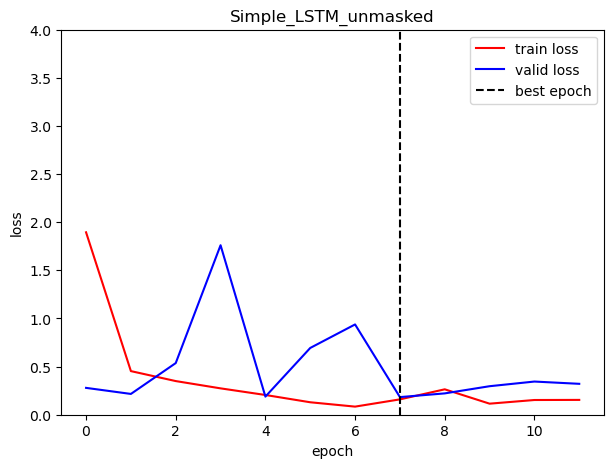

In [9]:
grid_model.test(test_loader)
grid_model.plot_losses(plot_title=f'{model_name}', save_filename=f'{model_name}_losses.png')